<a href="https://colab.research.google.com/github/abhranil-datascience/LSTM_POC/blob/master/LSTM_PredictStockPricePOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############################## Mount Drive ######################################## 
from google.colab import drive
drive.mount('/content/gdrive')
############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/MLandDLFullCourse/DL/LSTM')
########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')
########## Import Dataset ############
import pandas as pd
import numpy as np
TrainDataset=pd.read_csv('Google_Stock_Price_Train.csv')
TestDataset=pd.read_csv('Google_Stock_Price_Test.csv')
TrainData=TrainDataset.iloc[:,1:2].values
TestData=TestDataset.iloc[:,1:2].values
####### Take Last 60 Train data and append it before Test data ######
Last_sixty_train_data=TrainData[TrainData.shape[0]-60:TrainData.shape[0],:]
FinalTestData=np.concatenate((Last_sixty_train_data,TestData),axis=0)
########### Scale Dataset ###############
from sklearn.preprocessing import MinMaxScaler
sc_train=MinMaxScaler()
sc_test=MinMaxScaler()
TrainDataScaled=sc_train.fit_transform(TrainData)
TestDataScaled=sc_test.fit_transform(FinalTestData)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
########### Arrange Training Data to meet 60 timestep ##############
num_of_train_rows=TrainDataScaled.shape[0]
max_train_rows=num_of_train_rows-60
XTrain=[]
YTrain=[]
for row_num in range(0,max_train_rows):
  XTrainTemp=[]
  for var in range(0,60):
    if var==59:
      YTrain.append(TrainDataScaled[row_num+var+1][0])
    XTrainTemp.append(TrainDataScaled[row_num+var][0])
  XTrain.append(XTrainTemp)
import numpy as np
XTrainArray=np.array(XTrain)
YTrainArray=np.array(YTrain)
XTrainArray.reshape(max_train_rows,60)
YTrainArray.reshape(max_train_rows,1)
########### Arrange Test Data to meet 60 timestep ##############
num_of_test_rows=TestDataScaled.shape[0]
max_test_rows=num_of_test_rows-60
XTest=[]
YTest=[]
for row_num in range(0,max_test_rows):
  XTestTemp=[]
  for var in range(0,60):
    if var==59:
      YTest.append(TestDataScaled[row_num+var+1][0])
    XTestTemp.append(TestDataScaled[row_num+var][0])
  XTest.append(XTestTemp)
XTestArray=np.array(XTest)
YTestArray=np.array(YTest)
XTestArray.reshape(max_test_rows,60)
YTestArray.reshape(max_test_rows,1)
#############  Reshape Data to meet RNN batch expectations ####################
XTrainLSTM=XTrainArray.reshape(XTrainArray.shape[0],XTrainArray.shape[1],1)
YTrainLSTM=YTrainArray
XTestLSTM=XTestArray.reshape(XTestArray.shape[0],XTestArray.shape[1],1)
YTestLSTM=YTestArray

In [0]:
############# Build the LSTM ######################
filepath='bestLSTMModel.h5'
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
save_best_model=ModelCheckpoint(filepath, monitor='mean_absolute_error', verbose=1, save_best_only=True, mode='min')
ReduceLR=ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.8, patience=3, verbose=2,cooldown=1, min_delta=0.0020, min_lr=0.)
regressor=Sequential()
########### Layer 1 ################
regressor.add(LSTM(input_shape=(XTrainLSTM.shape[1],1),units=50,return_sequences=True))
regressor.add(Dropout(0.2))
########### Layer 2 ################
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
########### Layer 3 ################
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
########### Layer 4 ################
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
########### Layer 5 ################
regressor.add(LSTM(units=50,return_sequences=False,activation='relu'))
regressor.add(Dropout(0.2))
########### Output Layer ###################
regressor.add(Dense(units=1))
########### Compile Model ##################
regressor.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
########### Fitting the RNN ################
regressor.fit(x=XTrainLSTM,y=YTrainLSTM,batch_size=4,epochs=10,callbacks=[save_best_model,ReduceLR])

Epoch 1/10
1198/1198 [==============================] - 173s 145ms/step - loss: 0.0211 - mean_absolute_error: 0.0977

Epoch 00001: mean_absolute_error improved from inf to 0.09772, saving model to bestLSTMModel.h5
Epoch 2/10
1198/1198 [==============================] - 170s 142ms/step - loss: 0.0096 - mean_absolute_error: 0.0731

Epoch 00002: mean_absolute_error improved from 0.09772 to 0.07311, saving model to bestLSTMModel.h5
Epoch 3/10
1198/1198 [==============================] - 170s 142ms/step - loss: 0.0065 - mean_absolute_error: 0.0591

Epoch 00003: mean_absolute_error improved from 0.07311 to 0.05911, saving model to bestLSTMModel.h5
Epoch 4/10
1198/1198 [==============================] - 169s 141ms/step - loss: 0.0064 - mean_absolute_error: 0.0592

Epoch 00004: mean_absolute_error did not improve from 0.05911
Epoch 5/10
1198/1198 [==============================] - 170s 142ms/step - loss: 0.0056 - mean_absolute_error: 0.0555

Epoch 00005: mean_absolute_error improved from 0.059

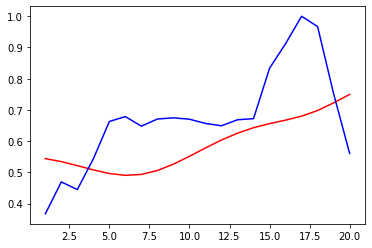

In [0]:
########### Load Best Model and Test ###########
########## Load Best Fit Model #############
BestRegressor=load_model(filepath)
YTestPred=BestRegressor.predict(XTestLSTM)
########## Plot Graph #####################
num_of_datapoints=YTestPred.shape[0]+1
import matplotlib.pyplot as plt
plt.plot(range(1,num_of_datapoints),YTestPred,c='red')
plt.plot(range(1,num_of_datapoints),YTestLSTM,c='blue')